---
This notebook generates image variants from the vanilla SVG cards.

---

In [6]:
import multiprocessing
import os
import random
import sys
import numpy as np
from PIL import Image, ImageFilter, ImageDraw


# Setup input and output directories.
input_directory = 'card-images'
output_directories = ('rgba-images', 'greyscaled-images', 'rgba-data', 'greyscaled-data')
for output_directory in output_directories:
  if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Run vars.
use_multiple_processors = True
variations_per_image = 900
  
# Cropping and resizing params.
original_card_width, original_card_height = 352, 550
aspect_ratio = 0.64
card_width = 50
card_height = int(card_width / aspect_ratio)

# White balance, rotation, blur and obfuscation params.
min_channel_high_end = 0.2
max_channel_low_end = 0.2
max_rotation = 5
max_blur = 3
max_rectangles = 10
max_rectangle_width, max_rectangle_height = card_width * 0.8, card_height * 0.8

# Seed the rng.
random.seed(2)


def preprocess(input_path):
  """Preprocess images."""
  # Load.
  image = Image.open(input_path)
  
  # Crop.
  image = image.crop((0, 0, original_card_width, original_card_height))
  
  # Resize.
  image = image.resize((card_width, card_height), resample=Image.ANTIALIAS)
    
  # Rotate.
  rotation = random.choice([-1, 1]) * max_rotation * random.random()
  if rotation < 0:
    rotation += 360
  image = image.rotate(rotation, expand=False, resample=Image.BICUBIC)
    
  # Obfuscate.
  drawing = ImageDraw.Draw(image)
  rectangles = int(round(random.random() * max_rectangles))
  for _ in range(rectangles):
    width = round(random.random() * max_rectangle_width)
    height = round(random.random() * max_rectangle_height)
    color = tuple([random.choice(np.arange(0, 256)) for _ in range(3)])
    x_shift = round(random.random() * card_width)
    y_shift = round(random.random() * card_height)
    drawing.rectangle([x_shift, y_shift, x_shift+width, y_shift+height], outline=color, fill=color)
    
  # Adjust white balance.
  rmin = random.random()*min_channel_high_end
  gmin = random.random()*min_channel_high_end
  bmin = random.random()*min_channel_high_end
  rmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  gmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  bmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  new_image = np.empty((card_height, card_width, 3), dtype=np.float32)
  image = np.multiply(np.array(image), 1/255.)
  new_image[:, :, 0] = np.add(np.multiply(image[:, :, 0], (rmax-rmin)), rmin)
  new_image[:, :, 1] = np.add(np.multiply(image[:, :, 1], (gmax-gmin)), gmin)
  new_image[:, :, 2] = np.add(np.multiply(image[:, :, 2], (bmax-bmin)), bmin)
  new_image = np.multiply(new_image, 255)
  image = Image.fromarray(np.uint8(new_image))

  # Blur.
  blur = max_blur * random.random()
  image = image.filter(ImageFilter.GaussianBlur(blur))

  # Greyscale.
  greyscaled_image = image.convert('L')
  
  # Get data.
  rgba_data = np.array(image).flatten()
  greyscaled_data = np.array(greyscaled_image).flatten()
  
  # Parse the input path.
  filename = input_path.split('/')[-1]
  number = filename.split('-')[0]
  color = filename.split('-')[1]
  texture = filename.split('-')[2]
  shape = filename.split('-')[3].split('.png')[0]
  
  # Save.
  output_filename_base = '%s-%s-%s-%s' % (number, color, texture, shape)
  output_filename_base += '-%0.2frmin-%0.2fgmin-%0.2fbmin-%0.2frmax-%0.2fgmax-%0.2fbmax' % (
    rmin, gmin, bmin, rmax, gmax, bmax)
  output_filename_base += '-%0.2fdeg' % rotation
  output_filename_base += '-%0.2fblur' % blur
  output_filename_base += '-%srect' % rectangles
  rgba_image_path = os.path.join('rgba-images', '%s.png' % output_filename_base)
  image.save(rgba_image_path)
  greyscaled_image_path = os.path.join('greyscaled-images', '%s.png' % output_filename_base)
  greyscaled_image.save(greyscaled_image_path)
  rgba_data_path = os.path.join('rgba-data', '%s.png' % output_filename_base)
  np.save(rgba_data_path, rgba_data)
  greyscaled_data_path = os.path.join('greyscaled-data', '%s.png' % output_filename_base)
  np.save(greyscaled_data_path, greyscaled_data)


# Input params.
image_paths = [os.path.join(input_directory, f) for f in os.listdir(input_directory)]
inputs = image_paths * variations_per_image

# Run it.
print 'generating %s images..' % len(inputs)
if use_multiple_processors:
  pool = multiprocessing.Pool()
  for i, _ in enumerate(pool.imap_unordered(preprocess, inputs, 1)):
    sys.stdout.write('\r%0.1f%% complete..' % (100. * i / len(inputs)))
  pool.close()
  pool.join()
  sys.stdout.write('\r100% complete.')
else:
  map(preprocess, inputs)
  print 'done.'

generating 72900 images..
100% complete.

---
Display a few.

---

3-purple-empty-diamond-0.04rmin-0.06gmin-0.13bmin-0.88rmax-0.90gmax-0.87bmax-2.41deg-0.73blur-4rect.png


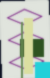

2-red-striped-oval-0.03rmin-0.10gmin-0.03bmin-0.98rmax-0.89gmax-1.00bmax-355.01deg-2.64blur-7rect.png


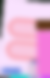

2-green-solid-oval-0.09rmin-0.08gmin-0.02bmin-0.88rmax-0.96gmax-0.92bmax-1.98deg-1.22blur-2rect.png


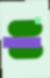

2-red-solid-bean-0.15rmin-0.01gmin-0.10bmin-0.93rmax-0.82gmax-0.90bmax-4.77deg-0.68blur-5rect.png


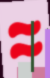

3-green-striped-bean-0.12rmin-0.10gmin-0.07bmin-0.95rmax-0.98gmax-0.87bmax-357.80deg-2.64blur-9rect.png


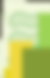

1-green-solid-diamond-0.18rmin-0.02gmin-0.04bmin-0.83rmax-0.99gmax-1.00bmax-1.18deg-2.39blur-7rect.png


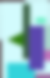

3-red-solid-diamond-0.10rmin-0.10gmin-0.15bmin-0.82rmax-0.83gmax-0.85bmax-357.02deg-2.65blur-0rect.png


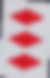

2-green-empty-diamond-0.07rmin-0.02gmin-0.06bmin-0.86rmax-0.81gmax-0.99bmax-358.66deg-2.94blur-7rect.png


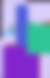

2-red-striped-diamond-0.19rmin-0.13gmin-0.06bmin-0.93rmax-0.99gmax-0.86bmax-4.79deg-0.91blur-2rect.png


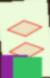

2-red-striped-oval-0.09rmin-0.20gmin-0.11bmin-0.95rmax-0.89gmax-0.95bmax-355.93deg-1.67blur-0rect.png


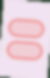

In [7]:
from IPython import display


output_directory = 'rgba-images'
images = random.sample(os.listdir(output_directory), 10)
for filename in images:
  print filename
  path = os.path.join(output_directory, filename)
  display.display(display.Image(filename=path))